Dataset contains New York Stock Exchange historical metrics extracted from annual SEC 10K fillings (2012-2016), should be enough to derive most of popular fundamental indicators.

We going to focus on clustering and apply unsupervised learning techniques to find the best candidate algorithm that accurately predicts wether a company has net profit or net loss. To do that, we will transform Net Income column into a binary representation of whether or not a company made profit, where 0 represents loss and 1 represents profit.

Net income indicates a company's profit after all of its expenses have been deducted from revenues. This number appears on a company's income statement and is also an indicator of a company's profitability.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from scipy.cluster import hierarchy

# Mute the sklearn and IPython warnings
import warnings
warnings.filterwarnings('ignore', module='sklearn')
pd.options.display.float_format = '{:.2f}'.format

In [ ]:
data = pd.DataFrame(pd.read_csv('/content/fundamentals.txt', sep=','))
data.head()

,Unnamed: 0,Ticker Symbol,Period Ending,Accounts Payable,Accounts Receivable,Add'l income/expense items,After Tax ROE,Capital Expenditures,Capital Surplus,Cash Ratio,Cash and Cash Equivalents,Changes in Inventories,Common Stocks,Cost of Revenue,Current Ratio,Deferred Asset Charges,Deferred Liability Charges,Depreciation,Earnings Before Interest and Tax,Earnings Before Tax,Effect of Exchange Rate,Equity Earnings/Loss Unconsolidated Subsidiary,Fixed Assets,Goodwill,Gross Margin,Gross Profit,Income Tax,Intangible Assets,Interest Expense,Inventory,Investments,Liabilities,Long-Term Debt,Long-Term Investments,Minority Interest,Misc. Stocks,Net Borrowings,Net Cash Flow,Net Cash Flow-Operating,Net Cash Flows-Financing,Net Cash Flows-Investing,Net Income,Net Income Adjustments,Net Income Applicable to Common Shareholders,Net Income-Cont. Operations,Net Receivables,Non-Recurring Items,Operating Income,Operating Margin,Other Assets,Other Current Assets,Other Current Liabilities,Other Equity,Other Financing Activities,Other Investing Activities,Other Liabilities,Other Operating Activities,Other Operating Items,Pre-Tax Margin,Pre-Tax ROE,Profit Margin,Quick Ratio,Research and Development,Retained Earnings,Sale and Purchase of Stock,"Sales, General and Admin.",Short-Term Debt / Current Portion of Long-Term Debt,Short-Term Investments,Total Assets,Total Current Assets,Total Current Liabilities,Total Equity,Total Liabilities,Total Liabilities & Equity,Total Revenue,Treasury Stock,For Year,Earnings Per Share,Estimated Shares Outstanding
0,0,AAL,2012-12-31,3068000000.00,-222000000.00,-1961000000.00,23.00,-1888000000.00,4695000000.00,53.00,1330000000.00,0.00,127000000.00,10499000000.00,78.00,0.00,223000000.00,1001000000.00,-1813000000.00,-2445000000.00,0.00,0.00,13402000000.00,0.00,58.00,14356000000.00,-569000000.00,869000000.00,632000000.00,580000000.00,306000000.00,473000000.00,7116000000.00,0.00,0.00,0.00,-1020000000.00,197000000.00,1285000000.00,483000000.00,-1571000000.00,-1876000000.00,2050000000.00,-1876000000.00,-4084000000.00,1124000000.00,386000000.00,148000000.00,1.00,2167000000.00,626000000.00,4524000000.00,-2980000000.00,1509000000.00,11000000.00,15147000000.00,-141000000.00,845000000.00,10.00,31.00,8.00,72.00,0.00,-9462000000.00,0.00,12977000000.00,1419000000.00,3412000000.00,23510000000.00,7072000000.00,9011000000.00,-7987000000.00,24891000000.00,16904000000.00,24855000000.00,-367000000.00,2012.00,-5.60,335000000.00
1,1,AAL,2013-12-31,4975000000.00,-93000000.00,-2723000000.00,67.00,-3114000000.00,10592000000.00,75.00,2175000000.00,0.00,5000000.00,11019000000.00,104.00,0.00,935000000.00,1020000000.00,-1324000000.00,-2180000000.00,0.00,0.00,19259000000.00,4086000000.00,59.00,15724000000.00,-346000000.00,2311000000.00,856000000.00,1012000000.00,-1181000000.00,-235000000.00,15353000000.00,0.00,0.00,0.00,2208000000.00,660000000.00,675000000.00,3799000000.00,-3814000000.00,-1834000000.00,1873000000.00,-1834000000.00,-4489000000.00,1560000000.00,559000000.00,1399000000.00,5.00,2299000000.00,1465000000.00,7385000000.00,-2032000000.00,1711000000.00,481000000.00,14915000000.00,-56000000.00,853000000.00,8.00,80.00,7.00,96.00,0.00,-11296000000.00,0.00,12913000000.00,1446000000.00,8111000000.00,42278000000.00,14323000000.00,13806000000.00,-2731000000.00,45009000000.00,42278000000.00,26743000000.00,0.00,2013.00,-11.25,163022222.22
2,2,AAL,2014-12-31,4668000000.00,-160000000.00,-150000000.00,143.00,-5311000000.00,15135000000.00,60.00,1768000000.00,0.00,7000000.00,15620000000.00,88.00,0.00,829000000.00,1342000000.00,4099000000.00,3212000000.00,0.00,0.00,23084000000.00,4091000000.00,63.00,27030000000.00,330000000.00,2240000000.00,887000000.00,1004000000.00,1799000000.00,-1026000000.00,16043000000.00,0.00,0.00,0.00,170000000.00,-146000000.00,3080000000.00,-315000000.00,-2911000000.00,2882000000.00,542000000.00,2882000000.00,2882000000.00,1771000000.00,800000000.00,4249000000.00,10.00,2060000000.00,898000000.00,7059000000.00,-4559000000.00,817000000

In [ ]:
data.isnull().sum()

Unnamed: 0                        0
Ticker Symbol                     0
Period Ending                     0
Accounts Payable                  0
Accounts Receivable               0
                               ... 
Total Revenue                     0
Treasury Stock                    0
For Year                        173
Earnings Per Share              219
Estimated Shares Outstanding    219
Length: 79, dtype: int64

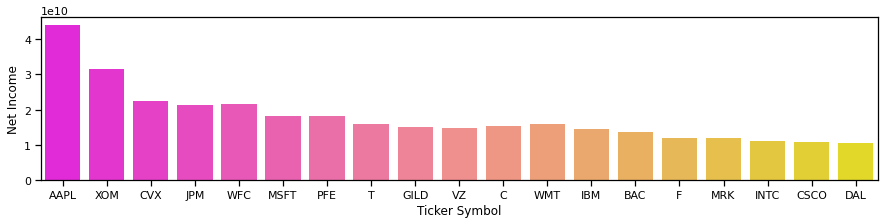

In [ ]:
plt.figure(figsize = (15, 3))
dt = data.sort_values(by = 'Net Income', ascending=False).head(50)
sns.set_context("notebook")

sns.barplot(x = dt['Ticker Symbol'], y =data['Net Income'], palette=("spring"), ci=None)

# Feature Transformation


*   Drop Unnamed: 0, Ticker Symbol and Period Ending column as they don't carry any information
*   Drop columns with missing values
*   Make sure all the columns are continuous which is what we need for K-means clustering
*   Transform Net Income into a binary column
*   Ensure the data is scaled and normally distributed


In [ ]:
data.drop(['Unnamed: 0', 'Ticker Symbol', 'Period Ending'],axis = 1, inplace=True)
data.dropna(axis=1,inplace=True)

In [ ]:
data.isnull().sum().all() == 0

True

In [ ]:
data.dtypes.all() == 'float64' # all floats except Ticker Symbol

True

In [ ]:
data['Net Income'] = data['Net Income'].apply(lambda x : 1 if x > 0 else 0)

In [ ]:
data['Net Income'].value_counts()

1    1679
0     102
Name: Net Income, dtype: int64

In [ ]:
log_columns = data.skew().sort_values(ascending=False)
log_columns = log_columns.loc[log_columns > 0.75]

log_columns

Pre-Tax ROE                                           18.00
After Tax ROE                                         15.98
Other Operating Activities                            15.83
Minority Interest                                     15.77
Equity Earnings/Loss Unconsolidated Subsidiary        14.91
Accounts Receivable                                   14.46
Common Stocks                                         12.15
Short-Term Debt / Current Portion of Long-Term Debt   11.88
Non-Recurring Items                                   11.80
Long-Term Debt                                        11.36
Interest Expense                                      11.28
Other Liabilities                                     11.07
Short-Term Investments                                10.87
Cash and Cash Equivalents                             10.11
Intangible Assets                                     10.03
Add'l income/expense items                             9.98
Other Current Liabilities               

In [ ]:
# The log transformations
for col in log_columns.index:
    data[col] = np.log1p(data[col])

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
data.dropna(axis=1,inplace=True)

In [ ]:
sc = StandardScaler()
feature_columns = [x for x in data.columns if x not in 'Net Income']
for col in feature_columns:
    data[col] = sc.fit_transform(data[[col]])

data.head(4)

,Accounts Payable,After Tax ROE,Capital Expenditures,Cash and Cash Equivalents,Changes in Inventories,Common Stocks,Cost of Revenue,Deferred Asset Charges,Deferred Liability Charges,Effect of Exchange Rate,Fixed Assets,Goodwill,Gross Margin,Intangible Assets,Interest Expense,Inventory,Investments,Long-Term Debt,Long-Term Investments,Net Borrowings,Net Cash Flows-Financing,Net Cash Flows-Investing,Net Income,Net Income Adjustments,Net Receivables,Operating Margin,Other Assets,Other Current Assets,Other Current Liabilities,Other Equity,Other Investing Activities,Other Liabilities,Pre-Tax Margin,Pre-Tax ROE,Profit Margin,Research and Development,Sale and Purchase of Stock,Short-Term Debt / Current Portion of Long-Term Debt,Short-Term Investments,Total Assets,Total Current Assets,Total Current Liabilities,Total Liabilities,Total Liabilities & Equity,Total Revenue,Treasury Stock
0,0.35,0.30,-0.21,0.24,0.17,0.53,0.42,-0.84,0.58,0.24,0.59,-1.92,0.44,0.65,0.63,0.63,0.16,0.42,-1.16,-0.29,0.10,0.11,0,0.69,0.22,-2.19,0.53,0.57,0.97,-0.77,0.13,0.75,-0.31,0.31,-0.27,-0.59,0.28,0.68,1.48,0.26,0.52,0.60,0.61,0.01,0.84,0.25
1,0.48,1.39,-0.63,0.51,0.17,-0.11,0.43,-0.84,0.73,0.24,0.68,0.59,0.48,0.76,0.68,0.68,-0.03,0.54,-1.16,0.31,0.47,-0.10,0,0.62,0.29,-0.95,0.54,0.68,1.02,-0.46,0.28,0.75,-0.57,1.20,-0.42,-0.59,0.28,0.68,1.57,0.70,0.60,0.65,1.00,0.70,0.90,0.28
2,0.47,2.17,-1.36,0.40,0.17,-0.04,0.49,-0.84,0.71,0.24,0.72,0.59,0.64,0.75,0.68,0.68,0.35,0.55,-1.16,-0.06,0.02,-0.02,1,0.12,0.31,-0.26,0.52,0.62,1.01,-1.29,0.32,0.70,-0.57,1.86,-0.42,-0.59,-0.10,0.70,1.54,0.71,0.58,0.65,0.94,0.71,1.28,0.28
3,0.49,2.11,-1.64,0.13,0.17,-0.07,0.43,1.41,0.69,0.24,0.77,0.59,1.03,0.75,0.68,0.67,0.18,0.57,-1.16,0.43,-0.09,-0.27,1,-1.08,0.27,0.16,0.52,0.60,1.00,-1.35,0.16,0.68,-0.20,1.23,0.78,-0.59,-1.12,0.74,1.54,0.80,0.56,0.65,0.97,0.80,1.25,0.28


# Train models
*   Fit a K-means clustering model with two clusters and 
*   Fit 2 Agglomerative clustering models with two clusters (ward-link and complete-link clustering)
*   Compare the results to those obtained by K-means with regards to wine color by reporting the number of red and white observations in each cluster for both K-means and agglomerative clustering.
*   Visualize the dendrogram produced by agglomerative clustering

## K-Means

In [ ]:
km = KMeans(n_clusters=2, random_state=42)
km = km.fit(data[feature_columns])

data['kmeans'] = km.predict(data[feature_columns])
(data[['Net Income','kmeans']]
 .groupby(['kmeans','Net Income'])
 .size()
 .to_frame()
 .rename(columns={0:'number'}))

number
kmeans Net Income        
0      0                8
       1              295
1      0               94
       1             1384

### Agglomerative Clustering

In [ ]:
for linkage in ['complete', 'ward']:
    ag = AgglomerativeClustering(n_clusters=2, linkage=linkage, compute_full_tree=True)
    ag = ag.fit(data[feature_columns])
    data[str('agglom_'+linkage)] = ag.fit_predict(data[feature_columns])

In [ ]:
(data[['Net Income','agglom_ward']]
 .groupby(['Net Income','agglom_ward'])
 .size()
 .to_frame()
 .rename(columns={0:'number'}))

number
Net Income agglom_ward        
0          0                13
           1                89
1          0               323
           1              1356

In [ ]:
(data[['Net Income','agglom_complete']]
     .groupby(['Net Income','agglom_complete'])
     .size()
     .to_frame()
     .rename(columns={0:'number'}))

number
Net Income agglom_complete        
0          0                   102
1          0                  1671
           1                     8

In [ ]:
# Comparing AgglomerativeClustering with KMeans
(data[['Net Income','agglom_complete', 'agglom_ward','kmeans']]
 .groupby(['Net Income', 'agglom_complete', 'agglom_ward', 'kmeans'])
 .size()
 .to_frame()
 .rename(columns={0:'number'}))

number
Net Income agglom_complete agglom_ward kmeans        
0          0               0           0            8
                                       1            5
                           1           1           89
1          0               0           0          287
                                       1           28
                           1           1         1356
           1               0           0            8

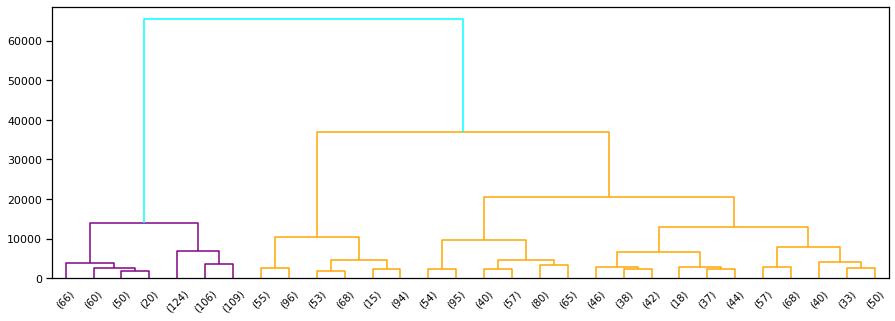

In [ ]:
Z = hierarchy.linkage(ag.children_, method='ward')

fig, ax = plt.subplots(figsize=(15,5))


hierarchy.set_link_color_palette(['purple', 'orange'])

den = hierarchy.dendrogram(Z, orientation='top', 
                           p=30, truncate_mode='lastp',
                           show_leaf_counts=True, ax=ax,
                           above_threshold_color='cyan')